## Задание

Реализовать с помощью `Numpy` класс `MyMLP`, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

1. Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется.
2. Обеспечивать выбор следующих функции активации в рамках каждого слоя: `ReLU`, `sigmoid`, `linear`.
3. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации).
4. В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча)
5. Поддерживать использование `l1`, `l2` и `l1l2` регуляризаций.

Самостоятельно выбрать наборы данных (классификация и регрессия). Провести эксперименты (различные конфигурации сети: количество слоев, нейронов, функции активации, скорость обучения и тп. — минимум 5 различных конфигураций) и сравнить результаты работы (оценка качества модели + время обучения и инференса) реализованного класса `MyMLP` со следующими моделям (в одинаковых конфигурациях):

*   MLPClassifier/MLPRegressor из sklearn
*   TensorFlow
*   Keras
*   PyTorch

Результат представить в виде .ipynb блокнота, содержащего весь необходимый код и визуализации сравнения реализаций для рассмотренных конфигураций.


###  Функции активации и их производные

#### ReLU:
$$
f(z) = \max(0, z) \\
f'(z) = \begin{cases}
1, & \text{если } z > 0 \\
0, & \text{если } z \leq 0
\end{cases}
$$

#### LReLU:
$$
f(z) = \begin{cases}
z, & \text{если } z > 0 \\
\alpha z, & \text{если } z \leq 0
\end{cases} \\
f'(z) = \begin{cases}
1, & \text{если } z > 0 \\
\alpha, & \text{если } z \leq 0
\end{cases}
$$

#### Sigmoid:
$$
f(z) = \frac{1}{1 + e^{-z}} \\
f'(z) = f(z)(1 - f(z))
$$

#### Softmax (для многоклассовой классификации):
$$
f(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}} \\
\frac{\partial f(z_i)}{\partial z_j} = \begin{cases}
f(z_i)(1 - f(z_i)), & \text{если } i = j \\
-f(z_i)f(z_j), & \text{если } i \neq j
\end{cases}
$$

###  Регуляризация

#### L1 регуляризация:
$$
\frac{\partial R}{\partial W} = \lambda \cdot \text{sign}(W)
$$

#### L2 регуляризация:
$$
\frac{\partial R}{\partial W} = 2\lambda W
$$

#### L1L2 регуляризация:
$$
\frac{\partial R}{\partial W} = \lambda_1 \cdot \text{sign}(W) + 2\lambda_2 W
$$


## Реализация классов

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re
from sklearn.model_selection import train_test_split

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
class FullyConnectedLayer:

    ACTIVATION_FUNCTIONS = {
        'ReLU': {
            'func': lambda x: np.maximum(x, 0),
            'derivative': lambda x: np.where(x >= 0, 1, 0)
        },
        'LReLU': {
            'func': lambda a, x: np.where(x >= 0, x, a * x),
            'derivative': lambda a, x: np.where(x >= 0, 1, a)
        },
        'None': {
            'func': lambda x: x,
            'derivative': lambda x: 1
        },
        'Sigmoid': {
            'func': lambda x: 1 / (1 + np.exp(-x)),
            'derivative': lambda x: (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x))))
        },
        'Softmax': {
            'func': lambda x: np.exp(x - np.max(x, axis=1, keepdims=True)) / (np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True) + 1e-8)
        }
    }

    def __init__(self, size: tuple, activation_func: str, class_number: int = 0, a=0):
        self.size = size
        self.__weights = np.random.randn(size[0], size[1]) * np.sqrt(2. / size[0])
        self.__bias = np.random.random((1, size[1])) - 0.5
        self.__a = a

        if activation_func in FullyConnectedLayer.ACTIVATION_FUNCTIONS.keys():
            self.activation_func = activation_func
        else:
            raise Exception("No such activation function!")

        if activation_func == 'Softmax':
            self.__class_number = class_number


    def get_weights(self):
        return self.__weights, self.__bias

    def update_weights(self, dweights, dbias):
        self.__weights -= dweights
        self.__bias -= dbias

    def get_grad(self, data, answers=None):
        if self.activation_func == 'Softmax':
            probabilities = self.__get_probabilities(data)
            return probabilities - self.__one_hot(answers)
        else:
            if self.activation_func == 'LReLU':
                return FullyConnectedLayer.ACTIVATION_FUNCTIONS[self.activation_func]['derivative'](self.__a, data)
            else:
                return FullyConnectedLayer.ACTIVATION_FUNCTIONS[self.activation_func]['derivative'](data)

    def __get_probabilities(self, data):
        outputs = np.matmul(data, self.__weights) + self.__bias
        return FullyConnectedLayer.ACTIVATION_FUNCTIONS[self.activation_func]['func'](outputs)

    def __one_hot(self, answers):
        one_hot_answers = np.zeros((len(answers), self.__class_number))
        one_hot_answers[np.arange(len(answers)), answers] = 1
        return one_hot_answers

    def forward(self, data, answers=None):
        if data.shape[1] != self.__weights.shape[0]:
            raise ValueError(f"Несоответствие размерностей: данные {data.shape}, веса {self.__weights.shape}")
        matrix_pass = np.matmul(data, self.__weights) + self.__bias
        if self.activation_func == 'LReLU':
            activation = FullyConnectedLayer.ACTIVATION_FUNCTIONS[self.activation_func]['func'](self.__a, matrix_pass)
        else:
            activation = FullyConnectedLayer.ACTIVATION_FUNCTIONS[self.activation_func]['func'](matrix_pass)
        return activation

class FullyConnectedNetwork:
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: np.sign(_w), "l2": lambda _w: 2*_w, "l1l2": lambda _w: 2*_w + np.sign(_w)}
    def __init__(self, alpha=0.01, reg_type=None, lambda_=0, task_type='classification'):
        self.__layers = []
        self.__alpha = alpha
        self.__reg_type = reg_type
        self.__lambda = lambda_
        self.__task_type = task_type

    def add_layer(self, size: tuple, activation_func: str, class_number=0, a=0):
        if not self.__layers or self.__layers[-1].size[1] == size[0]:
            self.__layers.append(FullyConnectedLayer(size, activation_func, class_number, a))
        else:
            raise Exception("Wrong size of the layer!")

    def predict(self, data):
        current_output = data
        for layer in self.__layers:
            current_output = layer.forward(current_output)
        if self.__task_type == 'classification':
            return np.array([np.argmax(row) for row in current_output])
        else:
            return current_output

    def score(self, data, answers):
        predictions = self.predict(data)
        if self.__task_type == 'classification':
            return (predictions == answers).mean()
        else:
            return np.mean(np.abs(predictions - answers))  # MAE для регрессии

    def get_loss(self, data, answers):
        current_output = data
        for layer in self.__layers:
            current_output = layer.forward(current_output)

        if self.__task_type == 'classification':
            probabilities = current_output
            eps = 1e-8
            return -np.mean(np.log(probabilities[np.arange(len(answers)), answers] + eps))
        else:
            return np.mean((current_output - answers) ** 2)  # MAE для регрессии

    def change_alpha(self, new_alpha):
        self.__alpha = new_alpha

    def fit(self, data, answers):
        layer_outputs = [data]
        current_output = data

        # Forward pass
        for layer in self.__layers:
            current_output = layer.forward(current_output)
            layer_outputs.append(current_output)

        # Backward pass
        if self.__task_type == 'classification':
            current_gradient = self.__layers[-1].get_grad(layer_outputs[-2], answers)
        else:
            current_gradient = 2 * (current_output - answers) / len(data)

        for i in range(len(self.__layers)):
            layer = self.__layers[-(i+1)]
            prev_layer_output = layer_outputs[-(i+2)]

            d_weights = np.matmul(prev_layer_output.T, current_gradient) / len(data)
            d_bias = np.sum(current_gradient, axis=0, keepdims=True) / len(data)

            if self.__reg_type:
                reg_w = self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer.get_weights()[0])
                d_weights += reg_w

            layer.update_weights(self.__alpha * d_weights, self.__alpha * d_bias)

            if i < len(self.__layers) - 1:
                current_gradient = np.matmul(current_gradient, layer.get_weights()[0].T)
                if self.__layers[-(i+2)].activation_func != 'Softmax':
                    current_gradient *= self.__layers[-(i+2)].get_grad(layer_outputs[-(i+2)])

## Классификация

In [ ]:
# Тестирование FullyConnectedNetwork на наборе данных MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28 * 28) / 255.0
x_test = x_test.reshape(-1, 28 * 28) / 255.0

network = FullyConnectedNetwork(alpha=0.1, reg_type='l2', lambda_=0.002)
loss = []
accuracy = []

network.add_layer((784, 128), activation_func='ReLU')
network.add_layer((128, 64), activation_func='ReLU')
network.add_layer((64, 10), activation_func='Softmax', class_number=10)

for ep in range(30):
    network.fit(x_train, y_train)
    current_loss = network.get_loss(x_train, y_train)
    current_accuracy = network.score(x_train, y_train)
    loss.append((ep, current_loss))
    accuracy.append((ep, current_accuracy))
    if (ep + 1) % 10 == 0:
        print('Epoch:', ep + 1, 'Train acc:', current_accuracy, 'Loss:', current_loss)

Epoch: 10 Train acc: 0.5997 Loss: 1.6875443271930022
Epoch: 20 Train acc: 0.7200166666666666 Loss: 1.1590425864037486
Epoch: 30 Train acc: 0.7805 Loss: 0.8737307301898083


In [ ]:
# Тестирование на наборе данных (ECG Heartbeat Categorization Dataset), классификация на 5 классов
path = kagglehub.dataset_download("shayanfazeli/heartbeat") #
train = pd.read_csv(f"{path}/mitbih_train.csv", header=None)
test = pd.read_csv(f"{path}/mitbih_test.csv", header=None)
print(train.shape, test.shape)

x_train = train.iloc[:, :-1].values
y_train = train.iloc[:, -1].astype(int).values
x_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].astype(int).values

x_train = x_train / np.max(x_train)
x_test = x_test / np.max(x_test)

(87554, 188) (21892, 188)



Конфигурация 1:
Слои: [(187, 128, 5)], Активация: ReLU, Регуляризация: l2
Эпоха: 5, Точность на train: 0.8256, Loss: 1.1127
Эпоха: 10, Точность на train: 0.8277, Loss: 0.9602
Эпоха: 15, Точность на train: 0.8277, Loss: 0.8792
Эпоха: 20, Точность на train: 0.8277, Loss: 0.8338

Конфигурация 2:
Слои: [(187, 128, 64, 5)], Активация: ReLU, Регуляризация: l2
Эпоха: 5, Точность на train: 0.0861, Loss: 1.4237
Эпоха: 10, Точность на train: 0.8252, Loss: 1.0796
Эпоха: 15, Точность на train: 0.8277, Loss: 0.8977
Эпоха: 20, Точность на train: 0.8277, Loss: 0.8124

Конфигурация 3:
Слои: [(187, 256, 128, 5)], Активация: ReLU, Регуляризация: l2
Эпоха: 5, Точность на train: 0.8277, Loss: 0.9119
Эпоха: 10, Точность на train: 0.8277, Loss: 0.7774
Эпоха: 15, Точность на train: 0.8277, Loss: 0.7345
Эпоха: 20, Точность на train: 0.8277, Loss: 0.7144

Конфигурация 4:
Слои: [(187, 128, 5)], Активация: LReLU, Регуляризация: l2
Эпоха: 5, Точность на train: 0.8172, Loss: 1.1731
Эпоха: 10, Точность на train: 0

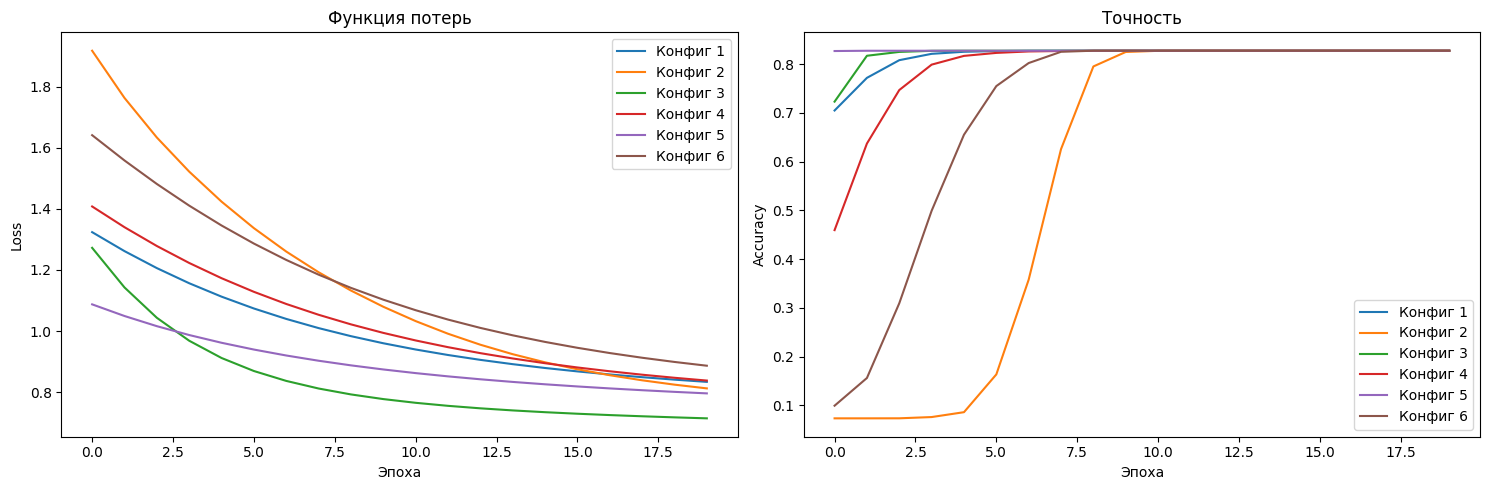

In [ ]:
# Определяем различные конфигурации гиперпараметров
configurations = [
    {'layers': [(x_train.shape[1], 128, 5)], 'activation': 'ReLU', 'reg_type': 'l2', 'lambda': 0.002},
    {'layers': [(x_train.shape[1], 128, 64, 5)], 'activation': 'ReLU', 'reg_type': 'l2', 'lambda': 0.002},
    {'layers': [(x_train.shape[1], 256, 128, 5)], 'activation': 'ReLU', 'reg_type': 'l2', 'lambda': 0.002},
    {'layers': [(x_train.shape[1], 128, 5)], 'activation': 'LReLU', 'reg_type': 'l2', 'lambda': 0.002, 'a': 0.1},
    {'layers': [(x_train.shape[1], 128, 5)], 'activation': 'ReLU', 'reg_type': 'l1', 'lambda': 0.002},
    {'layers': [(x_train.shape[1], 128, 5)], 'activation': 'ReLU', 'reg_type': 'l1l2', 'lambda': 0.002},
]

results = []
for i, config in enumerate(configurations):
    print(f'\nКонфигурация {i+1}:')
    print(f'Слои: {config["layers"]}, Активация: {config["activation"]}, Регуляризация: {config["reg_type"]}')

    network = FullyConnectedNetwork(alpha=0.01, reg_type=config['reg_type'], lambda_=config['lambda'])

    # Добавляем слои
    for j in range(len(config['layers'][0])-1):
        input_size = config['layers'][0][j]
        output_size = config['layers'][0][j+1]
        a = config.get("a", 0)
        activation = 'Softmax' if j == len(config['layers'][0])-2 else config['activation']
        class_number = 5 if j == len(config['layers'][0])-2 else None
        network.add_layer((input_size, output_size), activation_func=activation, class_number=class_number, a=a)

    loss = []
    accuracy = []
    for ep in range(20):
        network.fit(x_train, y_train)
        current_loss = network.get_loss(x_train, y_train)
        current_accuracy = network.score(x_train, y_train)
        loss.append((ep, current_loss))
        accuracy.append((ep, current_accuracy))
        if (ep + 1) % 5 == 0:
            print(f'Эпоха: {ep + 1}, Точность на train: {current_accuracy:.4f}, Loss: {current_loss:.4f}')

    results.append({
        'config': config,
        'loss': loss,
        'accuracy': accuracy
    })

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
for i, result in enumerate(results):
    loss_values = [x[1] for x in result['loss']]
    plt.plot(loss_values, label=f'Конфиг {i+1}')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
for i, result in enumerate(results):
    acc_values = [x[1] for x in result['accuracy']]
    plt.plot(acc_values, label=f'Конфиг {i+1}')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Регрессия

In [ ]:
df_regression = pd.read_csv('train_contest.csv')
y = df_regression['mean_salary']
df_regression = df_regression.drop(columns=['mean_salary'])

In [ ]:
def dataframe_convert_bool_to_int(dataframe):
    bool_columns = dataframe.select_dtypes(include=['bool']).columns
    for col in bool_columns:
        dataframe[col] = dataframe[col].astype(int)

    return dataframe


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    return text.strip()


def combine_dict_values(x, key):
    if pd.isna(x) or x == '[]':
        return None
    try:
        dict_list = ast.literal_eval(x)
        return ','.join([d[key] for d in dict_list])
    except:
        return None


def convert_to_lowercase(dataframe: pd.DataFrame) -> pd.DataFrame:
    text_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    for column in text_columns:
        dataframe[column] = dataframe[column].apply(lambda x: x.lower() if isinstance(x, str) else x)

    return dataframe

In [ ]:
def preprocess_data(salary, labels_to_drop=None):
    # Удаление не нужных признаков
    columns_to_drop_null = ["response_url", "sort_point_distance", "insider_interview", "relations", "working_days", "working_time_intervals", "working_time_modes", "department", 'address'] # address, department и area - вопрос как лучше с ними или без
    columns_to_drop_unused = ["alternate_url", "url", "immediate_redirect_url", "contacts", "published_at", "created_at"]
    salary = salary.drop(columns=columns_to_drop_null+columns_to_drop_unused)
    salary = dataframe_convert_bool_to_int(salary)

    # Достаем из json формата данные
    salary['area'] = salary['area'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['id']
    )
    salary['type'] = salary['type'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['id']
    )

    salary['employer'] = salary['employer'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['name']
    )
    salary['schedule'] = salary['schedule'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['id']
    )
    salary['experience'] = salary['experience'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['name']
    )

    salary['key_skills'] = salary['key_skills'].apply(combine_dict_values, key='name')
    salary['specialization_name'] = salary['specializations'].apply(combine_dict_values, key='name')
    salary['specialization_profarea_name'] = salary['specializations'].apply(combine_dict_values, key='profarea_name')
    salary['snippet'] = salary['snippet'].apply(
        lambda x: None if pd.isna(x) else ast.literal_eval(x)['requirement']
    )
    salary.drop(columns=['specializations'], inplace=True)

    salary["description"] = salary["description"].apply(preprocess_text)
    salary.fillna('empty', inplace=True)

    salary = convert_to_lowercase(salary)
    if labels_to_drop is not None:
        salary = salary.drop(columns=labels_to_drop)
        salary = pd.get_dummies(salary)
    salary = dataframe_convert_bool_to_int(salary)
    return salary

In [ ]:
df_regression_prep = preprocess_data(df_regression, labels_to_drop=["name", "snippet", "description", "key_skills", "employer"])

In [ ]:
df_regression_prep

,premium,has_test,response_letter_required,archived,accept_temporary,area_1,area_10,area_1011,area_1013,area_1014,...,"specialization_profarea_name_юристы,консультирование","specialization_profarea_name_юристы,консультирование,закупки","specialization_profarea_name_юристы,консультирование,консультирование,продажи,продажи,строительство, недвижимость","specialization_profarea_name_юристы,продажи,продажи,продажи,консультирование,строительство, недвижимость","specialization_profarea_name_юристы,страхование,банки, инвестиции, лизинг,консультирование","specialization_profarea_name_юристы,страхование,страхование,высший менеджмент,высший менеджмент,строительство, недвижимость","specialization_profarea_name_юристы,туризм, гостиницы, рестораны,банки, инвестиции, лизинг,продажи,начало карьеры, студенты,страхование","specialization_profarea_name_юристы,юристы,строительство, недвижимость,строительство, недвижимость","specialization_profarea_name_юристы,юристы,строительство, недвижимость,строительство, недвижимость,продажи,продажи","specialization_profarea_name_юристы,юристы,юристы,юристы,юристы"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30067,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30068,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30069,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30070,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = np.array(df_regression_prep)
y = np.array(y).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

network = FullyConnectedNetwork(alpha=0.01, reg_type='l2', lambda_=0.001, task_type='regression')
network.add_layer((X_train.shape[1], 32), activation_func='ReLU')
network.add_layer((32, 1), activation_func='None')

train_loss_history = []
test_loss_history = []
train_mse_history = []
test_mse_history = []

epochs = 200
for epoch in range(epochs):
    network.fit(X_train, y_train)

    train_loss = network.get_loss(X_train, y_train)
    test_loss = network.get_loss(X_test, y_test)
    train_mse = network.score(X_train, y_train)
    test_mse = network.score(X_test, y_test)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_mse_history.append(train_mse)
    test_mse_history.append(test_mse)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch: {epoch + 1}')
        print(f'Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'Train Accuracy: {train_mse:.4f}, Test Accuracy: {test_mse:.4f}\n')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_mse_history, label='Train MSE')
plt.plot(test_mse_history, label='Test MSE')
plt.title('MSE History')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()